# Github Data Analysis
* Sean Smith <swsmith@bu.edu> 
* Ann Ming Samborski <asambors@bu.edu>

# Questions We Strive to Address
1. What are the most popular coding languages? How has this changed over time? How does this data compare to StackOverflow?
2. Given the features shown below, can we predict number of stars? 
3. Is there a specific subset of the features below (besides the entirety) that optimizes the accuracy of star prediction? 
4. Does lines of code correlate with number of stars?
5. Do number of contributors correlate with number of stars?

# Differences From Our Initial Report
In our initial report submission, we focused on the popularity of languages and spoke mainly about how we'd like to study the rise and fall of different languages as a function of time. However, we realize that while we would love to compare GitHub's data to StackOverflow [1], there was still a lot more that we could do with the data collected. 

In addition to our desire to study different questions about the GitHub data, we also realized there is a slight skew to our collected data. It is reporting that the most common language is Ruby, but according to Stack Overflow surveys, JavaScript should have been the most popular. We only have a portion of GitHub's repositories so we cannot be certain one way or the other of which language is in fact most popular. Due to this inaccuracy, we decided to focus our efforts in another direction.

That being said, we now switch over to a focus on stars. We would like to see what combination of feature vectors (features shown below) can be used to best predict the number of stars a repository will have. Clearly, we would like to explore how to best minimize features required (i.e. is a question like (**2**) above a fair one to ask? Is it possible that one feature can be enough information to predict on?).

# References
1. [Stack Overflow Most Popular Languages 2017](https://stackoverflow.com/insights/survey/2017#technology-programming-languages)
2. [Pandas Scatter Plot](http://pandas.pydata.org/pandas-docs/stable/visualization.html#scatter-plot)
3. [Sampling](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sample.html)

## Dataset
We collected `137,100` repositories. We recognize more data would have been ideal, but the GitHub API rate limit, even with that increased thanks to GitHub Support, still restricts the amount of information we can make (especially because 1 repository requires 2 additional API calls). The information collected per repository is below.

| Name          | Description   |
| ------------- |:--------------|
| name          | Owner/Repository name |
| owner         | Owner name |
| watchers      | Number of watchers |
| stars         | Number of stars |
| forks         | Number of forks |
| type          | Type of account, organization or user |
| issues        | Number of issues|
| created_at    | Date created |
| pushed_at     | Date last pushed |
| updated_at    | Date last updated |
| size          | Size of repo in KB|
| open_issues   | Number of open issues |
| description   | Repository description |
| num_languages | Number of programming languages |
|language_1     | Most popular language |
|language_1_size| Most popular language size in bytes |
|language_2     | Second most popular language |
|language_2_size| Second most popular language size in bytes |
|language_3     | Third most popular language |
|language_3_size| Third most popular language size in bytes |

## Data Collection Code

Please see our initial report on our data and how we collected it for fleshed out details. 

## Data

In [27]:
# INCLUDES
import requests
from pprint import pprint
import collections
import pandas as pd
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
%matplotlib inline

import json
import random
import re
import numpy as np 
from datetime import datetime
import warnings

import matplotlib.cm as cm
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.preprocessing import scale
from sklearn.preprocessing import Normalizer
import sklearn.metrics as metrics
import scipy.sparse.linalg as linalg

from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm 

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# IGNORE WARNINGS
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=Warning)

In [3]:
# Read in data
df = pd.read_csv('github_data.csv')

In [4]:
df.head(5)

,name,owner,watchers,stars,forks,type,issues,created_at,pushed_at,updated_at,size,open_issues_count,description,num_languages,language_1,language_1_size,language_2,language_2_size,language_3,language_3_size
0,mojombo/grit,mojombo,59,1883,451,User,3,2007-10-29T14:37:16Z,2016-08-01T15:17:38Z,2017-04-19T11:01:12Z,7954,3,**Grit is no longer maintained. Check out libg...,1,Ruby,219981.0,NaN,NaN,NaN,NaN
1,wycats/merb-core,wycats,3,407,54,User,0,2008-01-12T05:50:53Z,2008-10-13T02:31:34Z,2017-04-23T16:05:54Z,3462,0,Merb Core: All you need. None you don't.,2,Ruby,948883.0,JavaScript,8925.0,NaN,NaN
2,rubinius/rubinius,rubinius,120,2692,612,Organization,211,2008-01-12T16:46:52Z,2017-04-22T23:00:00Z,2017-04-23T09:34:21Z,162886,211,The Rubinius Language Platform,13,Ruby,7352918.0,C++,2917738.0,C,522111.0
3,mojombo/god,mojombo,104,2036,479,User,112,2008-01-13T05:16:23Z,2017-03-01T00:00:23Z,2017-04-23T14:44:01Z,2639,112,Ruby process monitor,6,Ruby,283939.0,C,9261.0,CSS,6486.0
4,vanpelt/jsawesome,vanpelt,2,36,2,User,0,2008-01-13T06:04:19Z,2008-05-29T20:09:36Z,2017-03-29T18:09:21Z,192,0,Awesome JSON,2,JavaScript,126588.0,Ruby,9677.0,NaN,NaN


In [5]:
df.shape

(137100, 20)

In [6]:
df.type.value_counts()

User            130069
Organization      7031
Name: type, dtype: int64

## Most Popular Programming Language

In [7]:
# Top 20
df.language_1.value_counts()[:20]

Ruby            36351
JavaScript      15032
Python          11333
PHP              7484
Java             6384
C                6070
Perl             5027
C++              4391
Objective-C      2852
C#               2158
Shell            1999
Emacs Lisp       1802
VimL             1254
ActionScript     1072
Erlang            976
Haskell           900
Scala             774
Clojure           718
Lua               677
Common Lisp       520
Name: language_1, dtype: int64

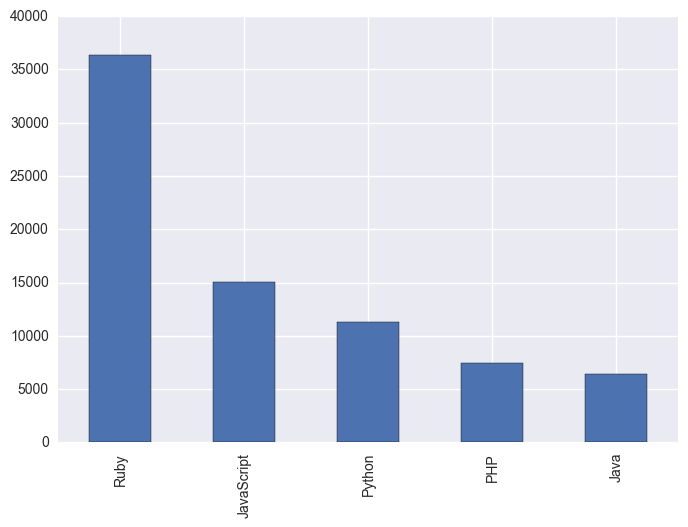

In [8]:
df.language_1.value_counts()[:5].plot.bar()

In [9]:
ruby_popularity = df[df.language_1 == 'Ruby'].filter(['language_1_size', 'created_at'])

Min: 2007-10-29T14:37:16Z
Max: 2010-06-24T18:44:50Z


(0, 20000000)

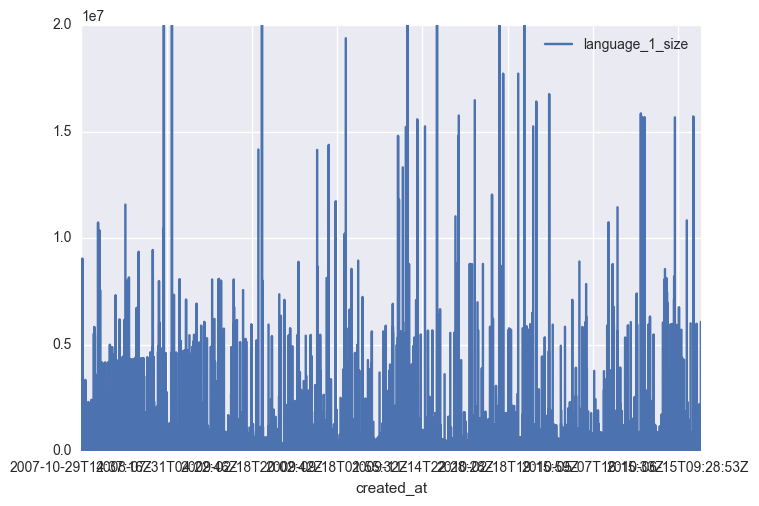

In [10]:
# import matplotlib.pyplot as plt
# axes = plt.subplot()
print("Min: %s" % ruby_popularity.created_at.min())
print("Max: %s" % ruby_popularity.created_at.max())

# bins = ruby_popularity.created_at.hist(bins=10)
# bins[0][0].x_label('created_at')
plt = ruby_popularity.plot(x='created_at', y='language_1_size')
plt.set_ylim([0,20000000])

# Forks vs Stars

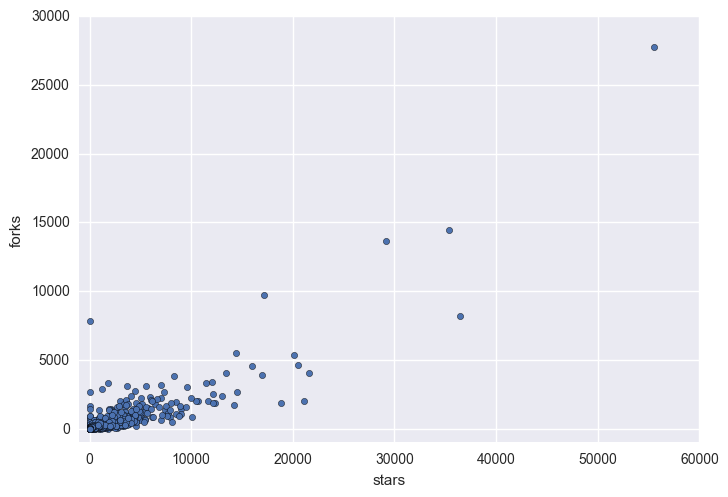

In [11]:
df.plot.scatter(x='stars', y='forks', xlim=[-1000,60000], ylim=[-1000,30000])

# Can we predict the number of stars a repository has?

In [12]:
# I am dumb, we need the stars

In [13]:
# Eliminate feature vectors that will not aid in the prediction of stars
guess_stars = df[['watchers', 'stars', 'forks', 'type', 'issues', 'size', 
                  'open_issues_count', 'num_languages', 'language_1', 
                  'language_1_size', 'language_2', 'language_2_size', 
                  'language_3', 'language_3_size']]
guess_stars.head(10)

,watchers,stars,forks,type,issues,size,open_issues_count,num_languages,language_1,language_1_size,language_2,language_2_size,language_3,language_3_size
0,59,1883,451,User,3,7954,3,1,Ruby,219981.0,NaN,NaN,NaN,NaN
1,3,407,54,User,0,3462,0,2,Ruby,948883.0,JavaScript,8925.0,NaN,NaN
2,120,2692,612,Organization,211,162886,211,13,Ruby,7352918.0,C++,2917738.0,C,522111.0
3,104,2036,479,User,112,2639,112,6,Ruby,283939.0,C,9261.0,CSS,6486.0
4,2,36,2,User,0,192,0,2,JavaScript,126588.0,Ruby,9677.0,NaN,NaN
5,2,66,5,User,0,156,0,1,JavaScript,48977.0,NaN,NaN,NaN,NaN
6,1,239,86,User,2,232,2,2,Ruby,10936.0,JavaScript,1531.0,NaN,NaN
7,2,151,16,User,1,473,1,2,Ruby,21237.0,JavaScript,2032.0,NaN,NaN
8,16,1629,283,User,27,1208,27,1,Ruby,145649.0,NaN,NaN,NaN,NaN
9,7,1036,309,User,37,1008,37,1,Ruby,132960.0,NaN,NaN,NaN,NaN


In [14]:
# Take a random sampling of the dataframe becuase every time I try to run it on the full dataset, 
# my kernel crashes and then so does my computer  
random_sampling = guess_stars.sample(frac=0.33, replace=True)
random_sampling.shape

(45243, 14)

In [21]:
random_sampling = random_sampling.replace(np.NaN, 0)
random_sampling.head(10)

,watchers,stars,forks,type,issues,size,open_issues_count,num_languages,language_1,language_1_size,language_2,language_2_size,language_3,language_3_size
96697,1,1,1,User,0,146,0,0,Ruby,0.0,0,0.0,0,0.0
66721,2,2,1,User,1,132,1,1,Perl,10561.0,0,0.0,0,0.0
14173,3,8,2,User,0,270,0,2,Ruby,16419.0,Objective-C,290.0,0,0.0
6353,2,2,0,User,0,89,0,1,Ruby,246.0,0,0.0,0,0.0
44984,2,1,1,User,0,190,0,0,Ruby,0.0,0,0.0,0,0.0
30530,2,1,0,User,0,116,0,0,0,0.0,0,0.0,0,0.0
102939,0,1,1,User,0,810,0,0,Ruby,0.0,0,0.0,0,0.0
12886,2,2,1,User,0,2741,0,0,Ruby,0.0,0,0.0,0,0.0
47604,2,1,0,User,0,184,0,2,Ruby,29416.0,JavaScript,148.0,0,0.0
33987,1,2,0,User,0,76,0,0,0,0.0,0,0.0,0,0.0


In [22]:
# Retrieve dummies
to_dummy = ['type', 'language_1', 'language_2', 'language_3']
df_dummies = pd.get_dummies(data=random_sampling, columns=to_dummy)
df_dummies.head(3)

,watchers,stars,forks,issues,size,open_issues_count,num_languages,language_1_size,language_2_size,language_3_size,...,language_3_Verilog,language_3_Vim script,language_3_VimL,language_3_Visual Basic,language_3_Vue,language_3_XML,language_3_XS,language_3_XSLT,language_3_Yacc,language_3_ooc
96697,1,1,1,0,146,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66721,2,2,1,1,132,1,1,10561.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14173,3,8,2,0,270,0,2,16419.0,290.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
estimate_stars_sample = df_dummies.drop(['stars'], 1)
estimate_stars_sample.head(5)

,watchers,forks,issues,size,open_issues_count,num_languages,language_1_size,language_2_size,language_3_size,type_Organization,...,language_3_Verilog,language_3_Vim script,language_3_VimL,language_3_Visual Basic,language_3_Vue,language_3_XML,language_3_XS,language_3_XSLT,language_3_Yacc,language_3_ooc
96697,1,1,0,146,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66721,2,1,1,132,1,1,10561.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14173,3,2,0,270,0,2,16419.0,290.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6353,2,0,0,89,0,1,246.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44984,2,1,0,190,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
stars_sample = pd.DataFrame(df_dummies['stars'], columns=['stars'])
stars_sample.head(5)

,stars
96697,1
66721,2
14173,8
6353,2
44984,1


In [25]:
print(stars_sample.max())
print(stars_sample.min())
print(df.loc[df['stars'] < 0].name) 

stars    55540
dtype: int64
stars    0
dtype: int64
46378                       sonian/sweat_shop
46380                      sonian/is_paranoid
66892    ubik86/rspec-haml-scaffold-generator
Name: name, dtype: object


You'll notice that it claims that some of these repositories have negative stars, which we previously believed to be impossible. However, besides `sweat_shop` (where I clicked the star and moved the value from -2 to 1, unstarred and it returned to 0), you can see that the stars truly are in the negatives.

## Some Visualizations 

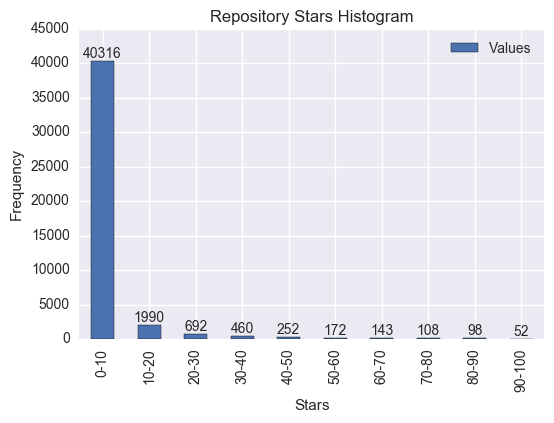

In [94]:
# Create histogram bins

def histogram(data, bin_size):
    max_stars = 100 #max(data.stars)
    d = []
    for i in range(0, math.ceil(max_stars / bin_size)):
        min_stars = i * bin_size
        max_stars = (i + 1) * bin_size
        m = {}
        m['Bin'] = "%d-%d" % (min_stars, max_stars)
        m['Values'] = len(data.loc[(data.stars >= min_stars) & (data.stars < max_stars)])
        d.append(m)
    return d

d = histogram(stars_sample, 10)
stars_hist = pd.DataFrame(d)
ax = stars_hist.plot(x='Bin', y='Values', kind='bar')
ax.set_title("Repository Stars Histogram")
ax.set_xlabel("Stars")
ax.set_ylabel("Frequency")

# Now make some labels
labels = stars_hist.Values

rects = ax.patches

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')


## K-Nearest Neighbors

In [67]:
X_train, X_test, y_train, y_test = train_test_split(estimate_stars_sample, stars_sample, test_size=0.4, random_state=0)

In [68]:
acc = []
for k in range(1,75):
    knn_digits = KNeighborsClassifier(n_neighbors=k)
    knn_digits.fit(X_train, pd.Series.ravel(y_train))
    y_digits_test_pred = knn_digits.predict(X_test)
    print("KNN test accuracy on prediction >50K, k = {}, acc = {}: ".format(
            k,knn_digits.score(X_test, y_test)))
    acc.append(knn_digits.score(X_test, y_test))

KNN test accuracy on prediction >50K, k = 1, acc = 0.4188308100342579: 
KNN test accuracy on prediction >50K, k = 2, acc = 0.4170626588573323: 
KNN test accuracy on prediction >50K, k = 3, acc = 0.4108188750138137: 
KNN test accuracy on prediction >50K, k = 4, acc = 0.41164769587799754: 
KNN test accuracy on prediction >50K, k = 5, acc = 0.41413415847054924: 
KNN test accuracy on prediction >50K, k = 6, acc = 0.4198806497955575: 
KNN test accuracy on prediction >50K, k = 7, acc = 0.42722952812465465: 
KNN test accuracy on prediction >50K, k = 8, acc = 0.4298817548900431: 
KNN test accuracy on prediction >50K, k = 9, acc = 0.4334733119681733: 
KNN test accuracy on prediction >50K, k = 10, acc = 0.4337495855895679: 
KNN test accuracy on prediction >50K, k = 11, acc = 0.43772792573765057: 
KNN test accuracy on prediction >50K, k = 12, acc = 0.4391092938446237: 
KNN test accuracy on prediction >50K, k = 13, acc = 0.43960658636313404: 
KNN test accuracy on prediction >50K, k = 14, acc = 0.4

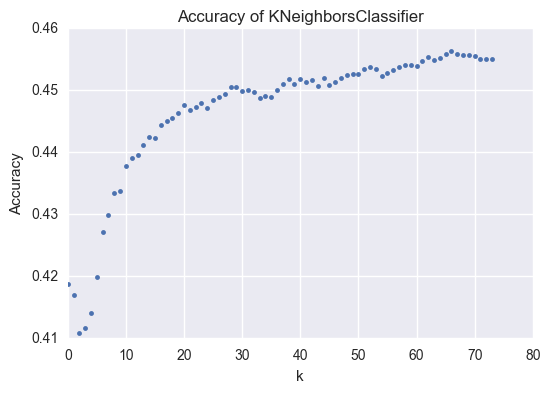

In [69]:
# ACCURACY PLOT OF KNEIGHBORS
plt.plot(acc,'.')
plt.xlabel('k')
_=plt.ylabel('Accuracy')
plt.title("Accuracy of KNeighborsClassifier")
plt.show()

In [71]:
max(acc)

0.45629351309536964

In [72]:
knneighbors = KNeighborsClassifier(n_neighbors=67)
knneighbors.fit(X_train, pd.Series.ravel(y_train))
y_pred_test = knneighbors.predict(X_test)

print('Accuracy on test data: {}'.format(knneighbors.score(X_test, y_test)))

Accuracy on test data: 0.45629351309536964


In [73]:
y_pred_train = knneighbors.predict(X_train)
print('Accuracy on training data: {}'.format(knneighbors.score(X_train, y_train)))

Accuracy on training data: 0.45905323263952846


## Discussion of Results on K-Nearest Neighbors 
While the accuracy of the test data appears to be low (coming in at only 45.6%), it is actually higher than we anticipated. If you consider what we are asking the algorithm to predict, it is solidly more impressive. The number of stars has no hard maximum. The minimum in this particular subset of the data is -2, and the maximum is 20533. The size of this space is large, and having an algorithm predict the correct integer star amount with 45.6% accuracy is in fact quite good.

## Decision Tree